# New code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

data_dir = '../data/intermediate-processing/rural'

# Importing the dataset
df = pd.read_parquet(os.path.join(data_dir, 'RFID_filtered.parquet'))

In [4]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm  # Use Jupyter notebook tqdm

# Initialize tqdm for notebooks
tqdm.pandas()

# Define the output directory
output_dir = '../data/processed/rural'
os.makedirs(output_dir, exist_ok=True)

# Import the dataset
data_dir = '../data/intermediate-processing/rural'
df = pd.read_parquet(os.path.join(data_dir, 'RFID_filtered.parquet'))

# Dictionary mapping unit number transitions to locations
location_map = {
    (1, 1): {'prior': [2, 3, 4, 5], 'location': 'red_tunnel', 'default': 'hub'},
    (2, 2): {'prior': [1, 3, 4, 5], 'location': 'orange_tunnel', 'default': 'hub'},
    (3, 3): {'prior': [1, 2, 4, 5], 'location': 'yellow_tunnel', 'default': 'hub'},
    (4, 4): {'prior': [1, 2, 3, 5], 'location': 'green_tunnel', 'default': 'hub'},
    (5, 5): {'prior': [1, 2, 3, 4], 'location': 'blue_tunnel', 'default': 'hub'},
    (1, 2): {'location': 'hub'},
    (1, 3): {'location': 'hub'},
    (1, 4): {'location': 'hub'},
    (1, 5): {'location': 'hub'},
    (2, 1): {'location': 'hub'},
    (2, 3): {'location': 'hub'},
    (2, 4): {'location': 'hub'},
    (2, 5): {'location': 'hub'},
    (3, 1): {'location': 'hub'},
    (3, 2): {'location': 'hub'},
    (3, 4): {'location': 'hub'},
    (3, 5): {'location': 'hub'},
    (4, 1): {'location': 'hub'},
    (4, 2): {'location': 'hub'},
    (4, 3): {'location': 'hub'},
    (4, 5): {'location': 'hub'},
    (5, 1): {'location': 'hub'},
    (5, 2): {'location': 'hub'},
    (5, 3): {'location': 'hub'},
    (5, 4): {'location': 'hub'},
    (1, 6): {'location': 'red_tunnel'},
    (6, 1): {'location': 'red_tunnel'},
    (6, 6): {'location': 'red_cage'},
    (2, 7): {'location': 'orange_tunnel'},
    (7, 2): {'location': 'orange_tunnel'},
    (7, 7): {'location': 'orange_cage'},
    (3, 8): {'location': 'yellow_tunnel'},
    (8, 3): {'location': 'yellow_tunnel'},
    (8, 8): {'location': 'yellow_cage'},
    (4, 9): {'location': 'green_tunnel'},
    (9, 4): {'location': 'green_tunnel'},
    (9, 9): {'location': 'green_cage'},
    (5, 10): {'location': 'blue_tunnel'},
    (10, 5): {'location': 'blue_tunnel'},
    (10, 10): {'location': 'blue_cage'},
    (1, 7): {'location': 'orange_tunnel'},
    (1, 8): {'location': 'yellow_tunnel'},
    (1, 9): {'location': 'green_tunnel'},
    (1, 10): {'location': 'blue_tunnel'},
    (2, 6): {'location': 'red_tunnel'},
    (2, 8): {'location': 'yellow_tunnel'},
    (2, 9): {'location': 'green_tunnel'},
    (2, 10): {'location': 'blue_tunnel'},
    (3, 6): {'location': 'red_tunnel'},
    (3, 7): {'location': 'orange_tunnel'},
    (3, 9): {'location': 'green_tunnel'},
    (3, 10): {'location': 'blue_tunnel'},
    (4, 6): {'location': 'red_tunnel'},
    (4, 7): {'location': 'orange_tunnel'},
    (4, 8): {'location': 'yellow_tunnel'},
    (4, 10): {'location': 'blue_tunnel'},
    (5, 6): {'location': 'red_tunnel'},
    (5, 7): {'location': 'orange_tunnel'},
    (5, 8): {'location': 'yellow_tunnel'},
    (5, 9): {'location': 'green_tunnel'}
}

# Initialize a list to collect all results
all_results = []

# Get the unique transponder codes
transponder_codes = df['Transponder code'].unique()

# Iterate over each transponder code with a progress bar
for transponder_code in tqdm(transponder_codes, desc='Processing Transponder Codes', position=0, leave=True):
    # Select the data for the current mouse
    mouse_data = df[df['Transponder code'] == transponder_code].copy()
    
    # Sort the DataFrame by 'Datetime'
    mouse_data = mouse_data.sort_values('Datetime')
    
    # Create a boolean mask to identify duplicate rows within a 1-second time window
    mask = mouse_data.groupby('Unit number')['Datetime'].diff().gt(pd.Timedelta(seconds=1))
    
    # Drop duplicate rows based on the boolean mask
    mouse_data = mouse_data[mask | ~mouse_data['Unit number'].duplicated()]
    
    # Reset the index of the DataFrame
    mouse_data = mouse_data.reset_index(drop=True)
    
    # Initialize an empty list to store the results for this mouse
    results = []
    
    # Iterate over each row of the mouse_data DataFrame with a progress bar
    for i in tqdm(range(len(mouse_data)), desc=f'Processing Rows for {transponder_code}', position=1, leave=True):
        current_unit = mouse_data.iloc[i]['Unit number']
        current_time = mouse_data.iloc[i]['Datetime']
        current_period = mouse_data.iloc[i].get('Period', 'UNKNOWN')  # Get 'Period' or set as 'UNKNOWN'
        
        if i == 0:
            # For the first row, set the location as "UNKNOWN"
            location = 'UNKNOWN'
        elif i == 1:
            # For the second row, set the location based on the transition
            prev_unit = mouse_data.iloc[i-1]['Unit number']
            transition = (prev_unit, current_unit)
            
            location = location_map.get(transition, {}).get('location', 'UNKNOWN')
        else:
            prev_unit = mouse_data.iloc[i-1]['Unit number']
            prev_location = results[-1][1]  # Get the previous location from the results list
            transition = (prev_unit, current_unit)
            
            loc_info = location_map.get(transition, {})
            if 'prior' in loc_info:
                if prev_unit in loc_info['prior']:
                    location = loc_info['location']
                else:
                    location = loc_info.get('default', 'UNKNOWN')
            else:
                location = loc_info.get('location', 'UNKNOWN')
            
            # Additional location adjustments
            if prev_location in ['green_tunnel', 'red_tunnel', 'orange_tunnel', 'yellow_tunnel', 'blue_tunnel']:
                hub_units = {'green_tunnel': 4, 'red_tunnel': 1, 'orange_tunnel': 2, 'yellow_tunnel': 3, 'blue_tunnel': 5}
                expected_unit = hub_units.get(prev_location, None)
                if expected_unit == current_unit and len(results) >= 2 and results[-2][1] == 'UNKNOWN':
                    results[-2][1] = 'hub'
            
            # Check for transitions from hub to tunnel
            if i >= 2:
                prev_prev_location = results[-2][1]
                if prev_prev_location == 'hub' and prev_location.endswith('_tunnel'):
                    location = 'hub'
        
        # Append the result to the list, including 'Period'
        results.append([current_time, location, current_unit, transponder_code, current_period])
    
    # Create a new DataFrame with the desired columns, including 'Period'
    result_df = pd.DataFrame(results, columns=['Time', 'Location', 'Unit number', 'Transponder code', 'Period'])
    
    # Apply additional logic for cage transitions
    for i in tqdm(range(1, len(result_df)), desc='Applying cage transitions', position=2, leave=True):
        prev_location = result_df.iloc[i-1]['Location']
        current_transition = (result_df.iloc[i-1]['Unit number'], result_df.iloc[i]['Unit number'])
        
        cage_transition_map = {
            ('red_cage', (6, 6)): 'red_tunnel',
            ('orange_cage', (7, 7)): 'orange_tunnel',
            ('yellow_cage', (8, 8)): 'yellow_tunnel',
            ('green_cage', (9, 9)): 'green_tunnel',
            ('blue_cage', (10, 10)): 'blue_tunnel',
        }
        
        if (prev_location, current_transition) in cage_transition_map:
            result_df.at[i, 'Location'] = cage_transition_map[(prev_location, current_transition)]
        
        # New logic: If previous row contains a 6 and current row contains a 6, then current location should be red_cage
        if result_df.iloc[i-1]['Unit number'] == 6 and result_df.iloc[i]['Unit number'] == 6:
            result_df.at[i, 'Location'] = 'red_cage'
    
    # Fill in the missing seconds in the time column
    start_time = result_df['Time'].min()
    end_time = result_df['Time'].max()
    all_seconds = pd.date_range(start=start_time, end=end_time, freq='s')
    
    # Merge the result DataFrame with the complete time range
    final_df = pd.merge(pd.DataFrame({'Time': all_seconds}), result_df, on='Time', how='left')
    
    # Apply the logic for transitions between cages and tunnels only if the value is UNKNOWN
    for i in tqdm(range(1, len(final_df)), desc='Applying transitions between cages and tunnels', position=3, leave=True):
        prev_location = final_df.iloc[i-1]['Location']
        current_location = final_df.iloc[i]['Location']
        
        if pd.notna(current_location) and current_location == 'UNKNOWN' and \
           pd.notna(prev_location) and (prev_location.endswith('_cage') or prev_location.endswith('_tunnel')) and \
           (current_location.endswith('_cage') or current_location.endswith('_tunnel')) and \
           prev_location != current_location:
            final_df.at[i, 'Location'] = 'hub'
    
    # Drop rows with any missing values
    final_df = final_df.dropna()
    
    # Reorder columns to include Transponder code and Period
    final_df = final_df[['Time', 'Location', 'Unit number', 'Transponder code', 'Period']]
    
    # Append the processed DataFrame to all_results
    all_results.append(final_df)

# Concatenate all results into a single DataFrame
processed_df = pd.concat(all_results, ignore_index=True)

# Save the final DataFrame as a Parquet file
processed_df.to_parquet(os.path.join(output_dir, 'RFID_processed.parquet'), index=False)

Processing Transponder Codes:   0%|          | 0/18 [00:00<?, ?it/s]

Processing Rows for 79FEADE:   0%|          | 0/36606 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/36605 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8212391 [00:00<?, ?it/s]

Processing Rows for 79FED08:   0%|          | 0/52345 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/52344 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8215631 [00:00<?, ?it/s]

Processing Rows for 7A2EFA1:   0%|          | 0/52971 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/52970 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8215642 [00:00<?, ?it/s]

Processing Rows for 79FEC60:   0%|          | 0/49637 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/49636 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8210207 [00:00<?, ?it/s]

Processing Rows for 7A40088:   0%|          | 0/53371 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/53370 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8216125 [00:00<?, ?it/s]

Processing Rows for 7A02701:   0%|          | 0/52704 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/52703 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8212074 [00:00<?, ?it/s]

Processing Rows for 7A2E90C:   0%|          | 0/30183 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/30182 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8207215 [00:00<?, ?it/s]

Processing Rows for 79FC3C6:   0%|          | 0/33665 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/33664 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8207776 [00:00<?, ?it/s]

Processing Rows for 7A3A179:   0%|          | 0/41052 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/41051 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8209758 [00:00<?, ?it/s]

Processing Rows for 7A3DC62:   0%|          | 0/40580 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/40579 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8201309 [00:00<?, ?it/s]

Processing Rows for 7A3FDE2:   0%|          | 0/73694 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/73693 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8214122 [00:00<?, ?it/s]

Processing Rows for 7A00464:   0%|          | 0/48745 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/48744 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8207367 [00:00<?, ?it/s]

Processing Rows for 7A3C016:   0%|          | 0/40488 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/40487 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8201871 [00:00<?, ?it/s]

Processing Rows for 7A3931B:   0%|          | 0/43594 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/43593 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8205563 [00:00<?, ?it/s]

Processing Rows for 7A3C408:   0%|          | 0/49369 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/49368 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8204750 [00:00<?, ?it/s]

Processing Rows for 79FEEA8:   0%|          | 0/35361 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/35360 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8200434 [00:00<?, ?it/s]

Processing Rows for 7A3DD05:   0%|          | 0/43953 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/43952 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8198168 [00:00<?, ?it/s]

Processing Rows for 79F8602:   0%|          | 0/23926 [00:00<?, ?it/s]

Applying cage transitions:   0%|          | 0/23925 [00:00<?, ?it/s]

Applying transitions between cages and tunnels:   0%|          | 0/8197012 [00:00<?, ?it/s]

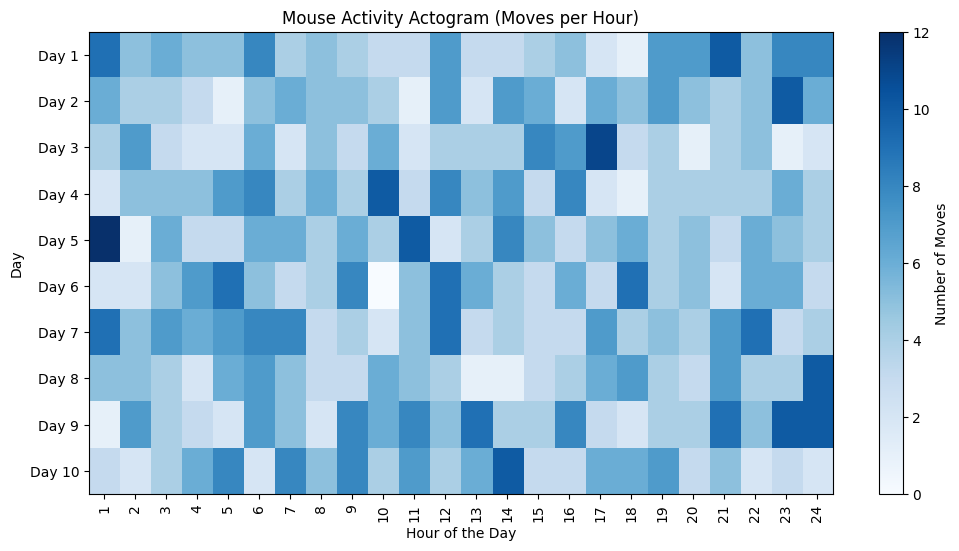

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example data setup (replace with your actual data)
# Generate a random dataset for the number of moves per hour over several days
np.random.seed(0)
days = 10  # for example, 10 days
hours_per_day = 24
data = np.random.poisson(5, (days, hours_per_day))  # Random moves data

# Convert data into a DataFrame
df = pd.DataFrame(data, columns=[f'Hour {i}' for i in range(1, hours_per_day + 1)])
df['Day'] = [f'Day {i+1}' for i in range(days)]
df = df.set_index('Day')

# Plotting the Actogram using a heatmap
plt.figure(figsize=(12, 6))
plt.imshow(df, aspect='auto', cmap='Blues')
plt.colorbar(label='Number of Moves')
plt.yticks(range(days), df.index)
plt.xticks(range(hours_per_day), range(1, hours_per_day + 1), rotation=90)
plt.xlabel('Hour of the Day')
plt.ylabel('Day')
plt.title('Mouse Activity Actogram (Moves per Hour)')
plt.show()


Master Co-occurrences:   0%|          | 0/28293 [00:00<?, ?it/s]

Period 1 - Co-occurrences:   0%|          | 0/6283 [00:00<?, ?it/s]

Period 2 - Co-occurrences:   0%|          | 0/6735 [00:00<?, ?it/s]

Period 3 - Co-occurrences:   0%|          | 0/5269 [00:00<?, ?it/s]

Period 4 - Co-occurrences:   0%|          | 0/5655 [00:00<?, ?it/s]

Period 5 - Co-occurrences:   0%|          | 0/4351 [00:00<?, ?it/s]

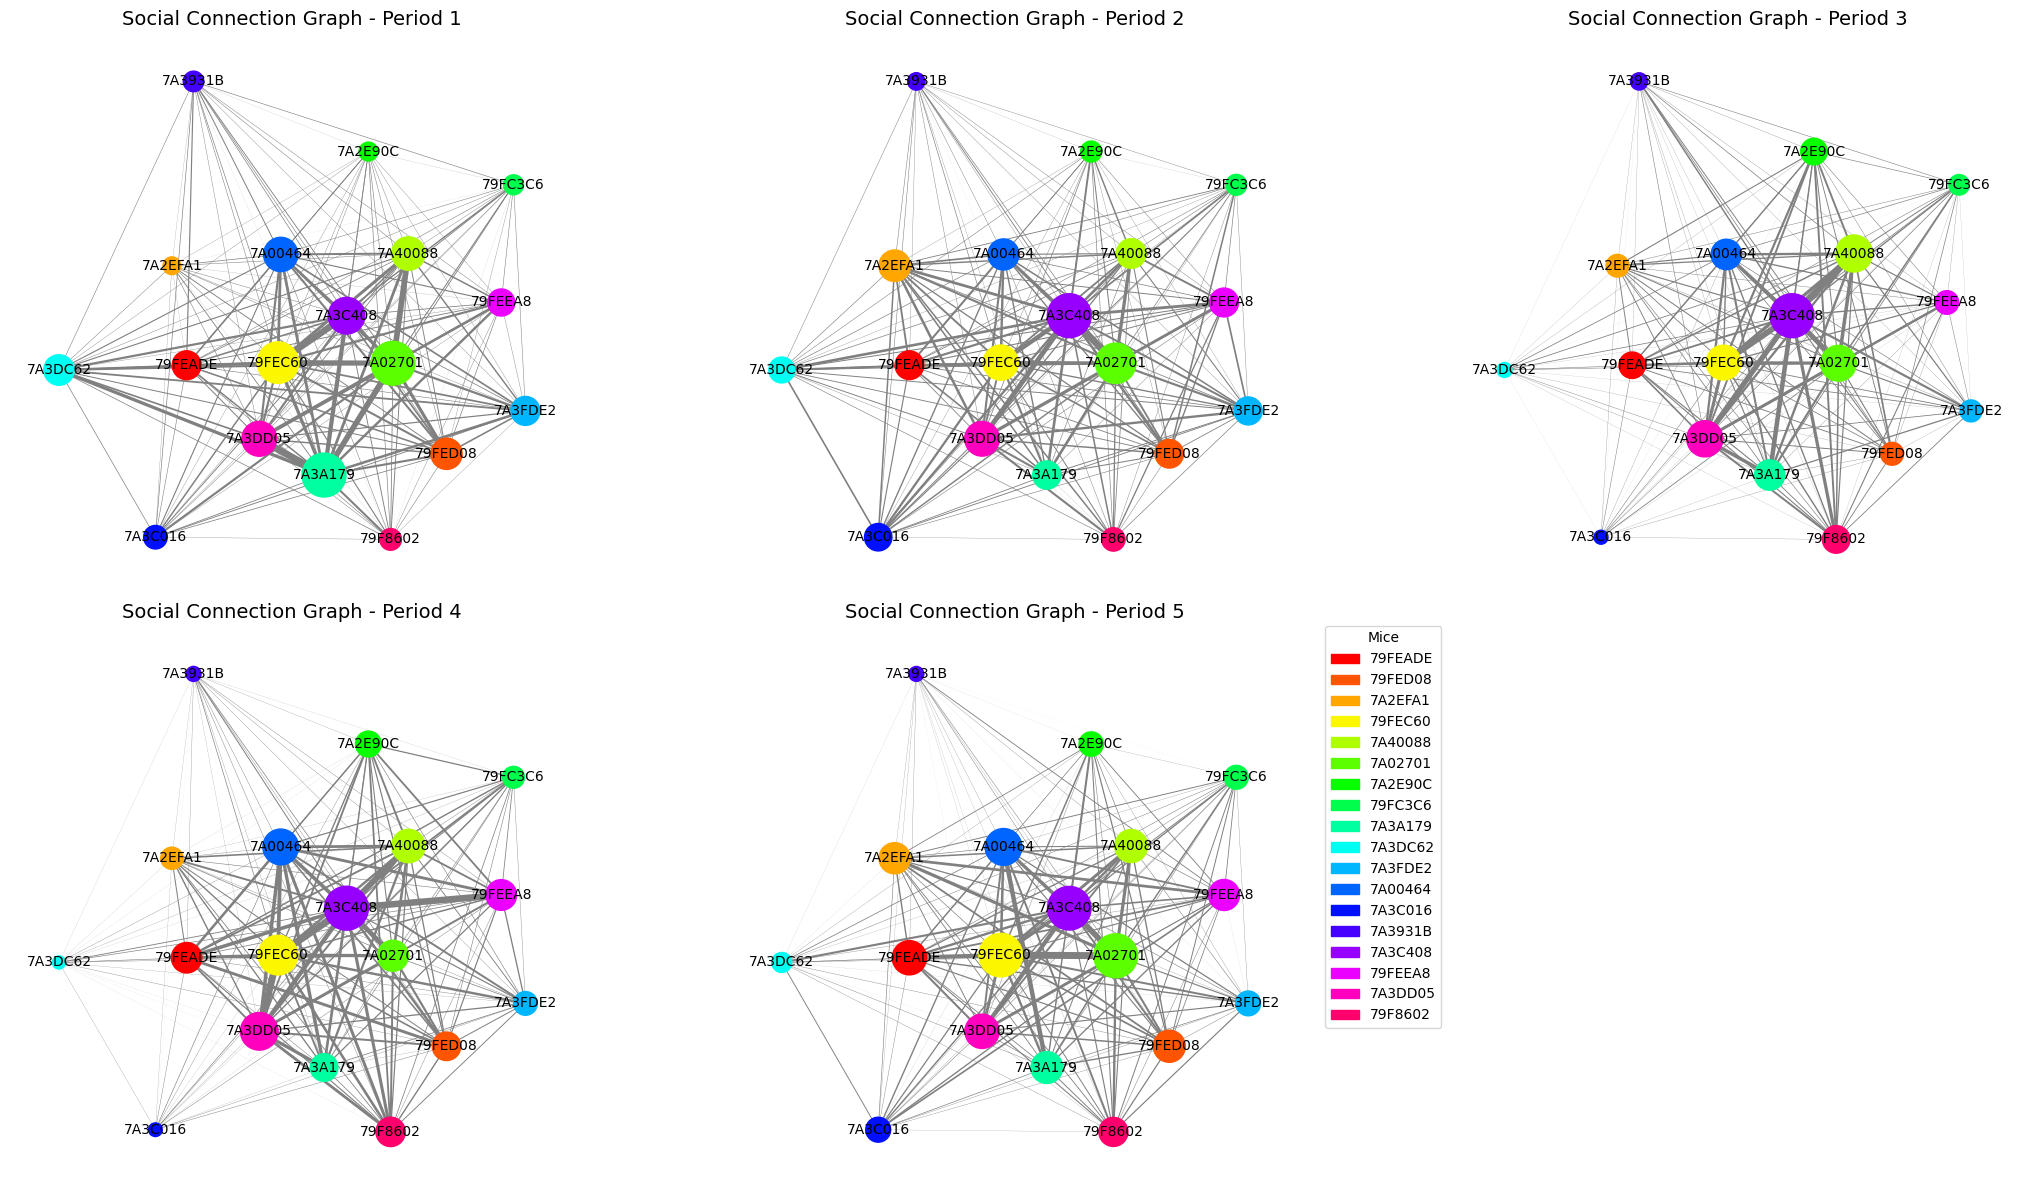

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm.notebook import tqdm  # Use Jupyter notebook tqdm
import matplotlib.patches as mpatches  # For creating custom legend

# Ensure processed_df is already loaded
# processed_df = pd.read_parquet(os.path.join(output_dir, 'RFID_processed.parquet'))

# Define the Periods to analyze
periods = [1, 2, 3, 4, 5]

# Initialize a color map for consistency across periods
mice = processed_df['Transponder code'].unique()
color_map = plt.get_cmap('hsv', len(mice) + 1)  # Updated to use plt.get_cmap
node_color_dict = {mouse: color_map(i) for i, mouse in enumerate(mice)}

# Create a master graph to compute consistent node positions
master_co_occurrence = {}

# Filter out 'hub' and 'tunnel' locations, keep only 'cage' locations
cage_locations_master = [loc for loc in processed_df['Location'].unique() if 'cage' in loc]
filtered_master_df = processed_df[processed_df['Location'].isin(cage_locations_master)].copy()

# Truncate 'Time' to the nearest minute
filtered_master_df['Time_minute'] = filtered_master_df['Time'].dt.floor('min')  # Replaced 'T' with 'min'

# Group by truncated Time and Location to find mice present at the same time and place
grouped_master = filtered_master_df.groupby(['Time_minute', 'Location'])['Transponder code'].apply(list).reset_index()

# Calculate co-occurrences across all periods for the master graph
for _, row in tqdm(grouped_master.iterrows(), total=grouped_master.shape[0], desc='Master Co-occurrences'):
    mice_present = row['Transponder code']
    if len(mice_present) > 1:
        # Generate all possible unique pairs of mice
        for pair in combinations(sorted(mice_present), 2):
            master_co_occurrence[pair] = master_co_occurrence.get(pair, 0) + 1  # Increment co-occurrence count

# Create the master graph
master_G = nx.Graph()

# Add nodes (mice)
master_G.add_nodes_from(mice)

# Add edges with weights
for pair, weight in master_co_occurrence.items():
    master_G.add_edge(pair[0], pair[1], weight=weight)

# Remove self-loops if any
master_G.remove_edges_from(nx.selfloop_edges(master_G))

# Compute positions using the master graph
pos = nx.spring_layout(master_G, k=0.5, seed=42)  # Fixed positions for all nodes

# Set up the matplotlib figure with subplots for each Period
fig, axes = plt.subplots(2, 3, figsize=(24, 12))  # Increased figsize for better readability
axes = axes.flatten()

for idx, period in enumerate(periods):
    ax = axes[idx]
    
    # Filter data for the current Period
    period_df = processed_df[processed_df['Period'] == period].copy()
    
    # Filter out 'hub' and 'tunnel' locations, keep only 'cage' locations
    cage_locations = [loc for loc in period_df['Location'].unique() if 'cage' in loc]
    filtered_df = period_df[period_df['Location'].isin(cage_locations)].copy()
    
    # Truncate 'Time' to the nearest minute
    filtered_df['Time_minute'] = filtered_df['Time'].dt.floor('min')  # Replaced 'T' with 'min'
    
    # Group by truncated Time and Location to find mice present at the same time and place
    grouped = filtered_df.groupby(['Time_minute', 'Location'])['Transponder code'].apply(list).reset_index()
    
    # Initialize a dictionary to hold co-occurrence times for the current Period
    co_occurrence = {}
    
    # Calculate co-occurrences with progress bar
    for _, row in tqdm(grouped.iterrows(), total=grouped.shape[0], desc=f'Period {period} - Co-occurrences', position=idx, leave=False):
        mice_present = row['Transponder code']
        if len(mice_present) > 1:
            # Generate all possible unique pairs of mice
            for pair in combinations(sorted(mice_present), 2):
                co_occurrence[pair] = co_occurrence.get(pair, 0) + 1  # Increment co-occurrence count
    
    # Create a graph for the current Period
    G = nx.Graph()
    
    # Add nodes (mice)
    G.add_nodes_from(mice)
    
    # Add edges with weights
    for pair, weight in co_occurrence.items():
        G.add_edge(pair[0], pair[1], weight=weight)
    
    # Remove self-loops if any
    G.remove_edges_from(nx.selfloop_edges(G))
    
    # Calculate weighted degree centrality (strength)
    strengths = dict(G.degree(weight='weight'))
    
    # Normalize strengths for node sizing
    max_strength = max(strengths.values()) if strengths else 1
    node_sizes = [ (strengths.get(node, 0) / max_strength) * 1000 for node in G.nodes() ]
    
    # Define edge widths based on weights (frequency)
    weights = [edata['weight'] for _, _, edata in G.edges(data=True)]
    if weights:
        max_weight = max(weights)
        normalized_weights = [ (weight / max_weight) * 5 for weight in weights ]
    else:
        normalized_weights = []
    
    # Draw nodes with assigned colors and sizes
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes, 
                           node_color=[node_color_dict[mouse] for mouse in G.nodes()])
    
    # Draw edges with widths based on weights
    nx.draw_networkx_edges(G, pos, ax=ax, width=normalized_weights, edge_color='gray')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10, font_family='sans-serif')
    
    # Set title for the subplot
    ax.set_title(f'Social Connection Graph - Period {period}', fontsize=14)
    ax.axis('off')

# Remove any empty subplots (if any)
for j in range(len(periods), len(axes)):
    fig.delaxes(axes[j])

# Create a single legend for all mice
legend_handles = [mpatches.Patch(color=node_color_dict[mouse], label=mouse) for mouse in mice]
# Place the legend outside the subplots
plt.legend(handles=legend_handles, title="Mice", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend
plt.show()

# old code

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
df = pd.read_csv('../data/raw/20240327.CSV', sep=';')

# DATA CLEANING
# Remove rows with transponder codes 0187A3F31B or 00379FED38
df = df[df['Transponder code'] != '0187A3F31B']
df = df[df['Transponder code'] != '00379FED38']

# Remove sensor data
df = df[df['Transponder code'] != '8000000000']
df = df[df['Transponder code'] != '8000000001']
df = df[df['Transponder code'] != '8000000002']
df = df[df['Transponder code'] != '8000000003']

# Get the unique transponder codes
transponder_codes = df['Transponder code'].unique()

# Dictionary mapping unit number transitions to locations
location_map = {
    (1, 1): {'prior': [2, 3, 4, 5], 'location': 'red_tunnel', 'default': 'hub'},
    (2, 2): {'prior': [1, 3, 4, 5], 'location': 'orange_tunnel', 'default': 'hub'},
    (3, 3): {'prior': [1, 2, 4, 5], 'location': 'yellow_tunnel', 'default': 'hub'},
    (4, 4): {'prior': [1, 2, 3, 5], 'location': 'green_tunnel', 'default': 'hub'},
    (5, 5): {'prior': [1, 2, 3, 4], 'location': 'blue_tunnel', 'default': 'hub'},
    (1, 2): {'location': 'hub'},
    (1, 3): {'location': 'hub'},
    (1, 4): {'location': 'hub'},
    (1, 5): {'location': 'hub'},
    (2, 1): {'location': 'hub'},
    (2, 3): {'location': 'hub'},
    (2, 4): {'location': 'hub'},
    (2, 5): {'location': 'hub'},
    (3, 1): {'location': 'hub'},
    (3, 2): {'location': 'hub'},
    (3, 4): {'location': 'hub'},
    (3, 5): {'location': 'hub'},
    (4, 1): {'location': 'hub'},
    (4, 2): {'location': 'hub'},
    (4, 3): {'location': 'hub'},
    (4, 5): {'location': 'hub'},
    (5, 1): {'location': 'hub'},
    (5, 2): {'location': 'hub'},
    (5, 3): {'location': 'hub'},
    (5, 4): {'location': 'hub'},
    (1, 6): {'location': 'red_tunnel'},
    (6, 1): {'location': 'red_tunnel'},
    (6, 6): {'location': 'red_cage'},
    (2, 7): {'location': 'orange_tunnel'},
    (7, 2): {'location': 'orange_tunnel'},
    (7, 7): {'location': 'orange_cage'},
    (3, 8): {'location': 'yellow_tunnel'},
    (8, 3): {'location': 'yellow_tunnel'},
    (8, 8): {'location': 'yellow_cage'},
    (4, 9): {'location': 'green_tunnel'},
    (9, 4): {'location': 'green_tunnel'},
    (9, 9): {'location': 'green_cage'},
    (5, 10): {'location': 'blue_tunnel'},
    (10, 5): {'location': 'blue_tunnel'},
    (10, 10): {'location': 'blue_cage'},
    (1, 7): {'location': 'orange_tunnel'},
    (1, 8): {'location': 'yellow_tunnel'},
    (1, 9): {'location': 'green_tunnel'},
    (1, 10): {'location': 'blue_tunnel'},
    (2, 6): {'location': 'red_tunnel'},
    (2, 8): {'location': 'yellow_tunnel'},
    (2, 9): {'location': 'green_tunnel'},
    (2, 10): {'location': 'blue_tunnel'},
    (3, 6): {'location': 'red_tunnel'},
    (3, 7): {'location': 'orange_tunnel'},
    (3, 9): {'location': 'green_tunnel'},
    (3, 10): {'location': 'blue_tunnel'},
    (4, 6): {'location': 'red_tunnel'},
    (4, 7): {'location': 'orange_tunnel'},
    (4, 8): {'location': 'yellow_tunnel'},
    (4, 10): {'location': 'blue_tunnel'},
    (5, 6): {'location': 'red_tunnel'},
    (5, 7): {'location': 'orange_tunnel'},
    (5, 8): {'location': 'yellow_tunnel'},
    (5, 9): {'location': 'green_tunnel'}
}

# Iterate over each transponder code
for transponder_code in transponder_codes:
    # Select the data for the current mouse
    mouse_data = df[df['Transponder code'] == transponder_code].copy()  # Create a copy of the slice
    
    # Convert the 'Date' and 'Time' columns to datetime
    mouse_data.loc[:, 'DateTime'] = pd.to_datetime(mouse_data['Date'] + ' ' + mouse_data['Time'], format='%d-%m-%Y %H:%M:%S')
    
    # Sort the DataFrame by 'DateTime'
    mouse_data = mouse_data.sort_values('DateTime')
    
    # Create a boolean mask to identify duplicate rows within a 1-second time window
    mask = mouse_data.groupby('Unit number')['DateTime'].diff().gt(pd.Timedelta(seconds=1))
    
    # Drop duplicate rows based on the boolean mask
    mouse_data = mouse_data[mask | ~mouse_data['Unit number'].duplicated()]
    
    # Reset the index of the DataFrame
    mouse_data = mouse_data.reset_index(drop=True)
    
    # Create a single time column with the desired format
    mouse_data.loc[:, 'Time'] = mouse_data['DateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # Drop the original 'Date' and 'Time' columns
    mouse_data = mouse_data.drop(['Date', 'Time'], axis=1)
    
    mouse_data = mouse_data[['DateTime', 'Unit number', 'Transponder code']]
    
    # Rename DateTime column to Time
    mouse_data = mouse_data.rename(columns={'DateTime': 'Time'})
    
    # Initialize an empty list to store the results
    results = []
    
    # Iterate over each row of the mouse_data DataFrame
    for i in range(len(mouse_data)):
        current_unit = mouse_data.iloc[i]['Unit number']
        current_time = mouse_data.iloc[i]['Time']
        
        if i == 0:
            # For the first row, set the location as "UNKNOWN"
            location = 'UNKNOWN'
        elif i == 1:
            # For the second row, set the location based on the transition
            prev_unit = mouse_data.iloc[i-1]['Unit number']
            transition = (prev_unit, current_unit)
            
            if transition in location_map:
                location = location_map[transition]['location']
            else:
                location = 'UNKNOWN'
        else:
            prev_unit = mouse_data.iloc[i-1]['Unit number']
            prev_location = results[-1][1]  # Get the previous location from the results list
            transition = (prev_unit, current_unit)
            
            if transition in location_map:
                if 'prior' in location_map[transition]:
                    if prev_unit in location_map[transition]['prior']:
                        location = location_map[transition]['location']
                    else:
                        location = location_map[transition]['default']
                else:
                    location = location_map[transition]['location']
            else:
                location = 'UNKNOWN'
            
            # Check if the mouse moved from a tunnel to a specific antenna unit number
            if prev_location == 'green_tunnel' and current_unit == 4:
                if results[-2][1] == 'UNKNOWN':
                    results[-2][1] = 'hub'  # Modify the location two rows before the current location
            elif prev_location == 'red_tunnel' and current_unit == 1:
                if results[-2][1] == 'UNKNOWN':
                    results[-2][1] = 'hub'
            elif prev_location == 'orange_tunnel' and current_unit == 2:
                if results[-2][1] == 'UNKNOWN':
                    results[-2][1] = 'hub'
            elif prev_location == 'yellow_tunnel' and current_unit == 3:
                if results[-2][1] == 'UNKNOWN':
                    results[-2][1] = 'hub'
            elif prev_location == 'blue_tunnel' and current_unit == 5:
                if results[-2][1] == 'UNKNOWN':
                    results[-2][1] = 'hub'
            
            # Check if the mouse moved from hub to tunnel to specific unit number
            if i >= 2:
                prev_prev_location = results[-2][1]  # Get the location two rows before the current location
                if prev_prev_location == 'hub' and prev_location == 'green_tunnel' and current_unit == 4:
                    location = 'hub'
                elif prev_prev_location == 'hub' and prev_location == 'red_tunnel' and current_unit == 1:
                    location = 'hub'
                elif prev_prev_location == 'hub' and prev_location == 'orange_tunnel' and current_unit == 2:
                    location = 'hub'
                elif prev_prev_location == 'hub' and prev_location == 'yellow_tunnel' and current_unit == 3:
                    location = 'hub'
                elif prev_prev_location == 'hub' and prev_location == 'blue_tunnel' and current_unit == 5:
                    location = 'hub'
        
        # Append the result to the list
        results.append([current_time, location, current_unit])
    
    # Create a new DataFrame with the desired columns
    result_df = pd.DataFrame(results, columns=['Time', 'Location', 'Unit number'])
    
    # Apply the additional logic
    for i in range(1, len(result_df)):
        prev_location = result_df.iloc[i-1]['Location']
        current_transition = (result_df.iloc[i-1]['Unit number'], result_df.iloc[i]['Unit number'])
        
        if prev_location == 'red_cage' and current_transition == (6, 6):
            result_df.at[i, 'Location'] = 'red_tunnel'
        elif prev_location == 'orange_cage' and current_transition == (7, 7):
            result_df.at[i, 'Location'] = 'orange_tunnel'
        elif prev_location == 'yellow_cage' and current_transition == (8, 8):
            result_df.at[i, 'Location'] = 'yellow_tunnel'
        elif prev_location == 'green_cage' and current_transition == (9, 9):
            result_df.at[i, 'Location'] = 'green_tunnel'
        elif prev_location == 'blue_cage' and current_transition == (10, 10):
            result_df.at[i, 'Location'] = 'blue_tunnel'
            
        # New logic: If previous row contains a 6 and current row contains a 6, then current location should be red_cage
        if result_df.iloc[i-1]['Unit number'] == 6 and result_df.iloc[i]['Unit number'] == 6:
            result_df.at[i, 'Location'] = 'red_cage'
    
    # Fill in the missing seconds in the time column
    start_time = pd.to_datetime(mouse_data['Time'].min())
    end_time = pd.to_datetime(mouse_data['Time'].max())
    all_seconds = pd.date_range(start=start_time, end=end_time, freq='S')
    
    # Merge the result DataFrame with the complete time range
    final_df = pd.merge(pd.DataFrame({'Time': all_seconds}), result_df, on='Time', how='left')
    
    # Apply the logic for transitions between cages and tunnels only if the value is UNKNOWN
    for i in range(1, len(final_df)):
        prev_location = final_df.iloc[i-1]['Location']
        current_location = final_df.iloc[i]['Location']
        
        if pd.notna(current_location) and current_location == 'UNKNOWN' and \
           pd.notna(prev_location) and (prev_location.endswith('_cage') or prev_location.endswith('_tunnel')) and \
           (current_location.endswith('_cage') or current_location.endswith('_tunnel')) and \
           prev_location != current_location:
            final_df.at[i, 'Location'] = 'hub'
    
    final_df['Location'] = final_df['Location'].fillna('UNKNOWN')
    final_df['Unit number'] = final_df['Unit number'].fillna(0).astype(int)
    
    # Save the final DataFrame as a CSV file
    final_df.to_csv(f'../data/processed/mouse_{transponder_code}_locations.csv', index=False)

C:\Users\joshf\AppData\Local\Temp\ipykernel_10784\2350769508.py:213: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  all_seconds = pd.date_range(start=start_time, end=end_time, freq='S')


KeyboardInterrupt: 

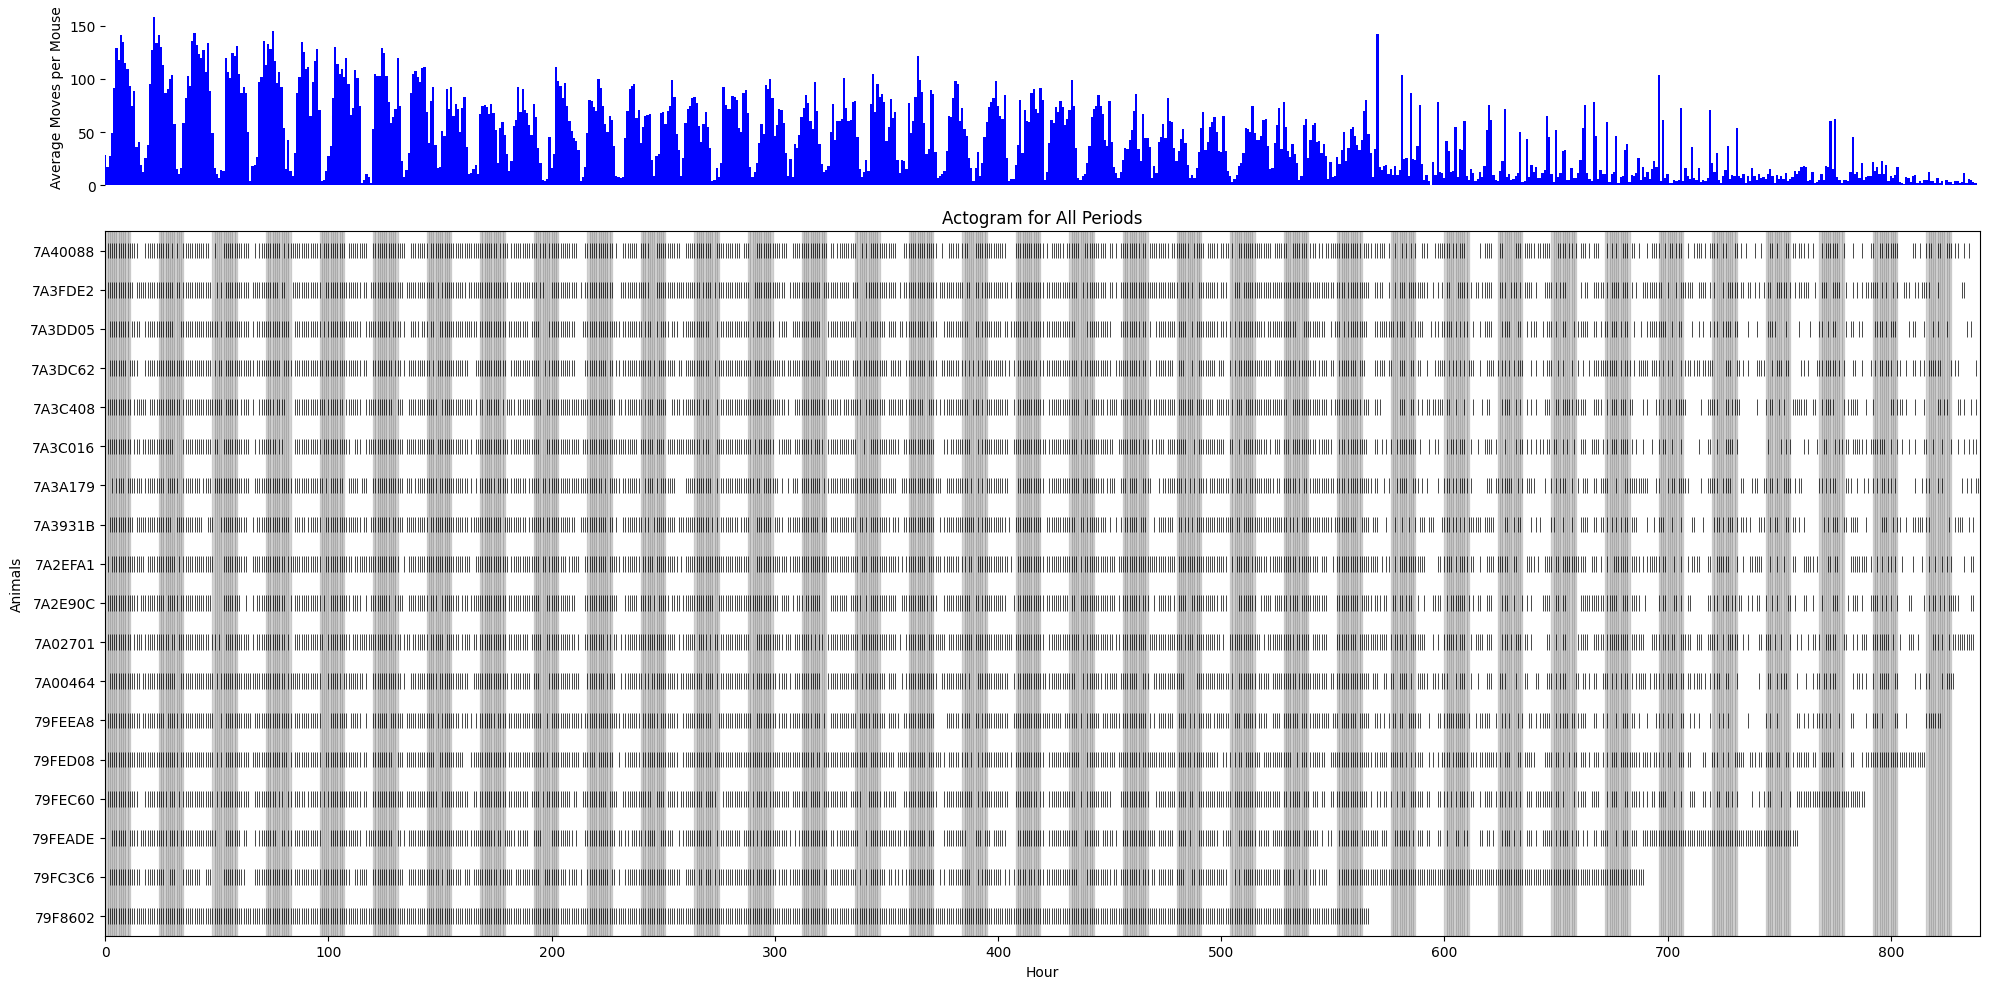

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Load the processed data
output_dir = '../data/processed/rural'
processed_file = os.path.join(output_dir, 'RFID_processed.parquet')
df = pd.read_parquet(processed_file)

# Convert 'Time' to datetime and set as index
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

# Remove 'UNKNOWN' locations if present (assuming 'Location' column exists)
if 'Location' in df.columns:
    df = df[df['Location'] != 'UNKNOWN']

# Sort the DataFrame by 'Transponder code' and 'Time' to ensure proper sequencing
df = df.sort_values(['Transponder code', 'Time'])

# Identify moves by detecting changes in 'Location' for each transponder
df['Prev_Location'] = df.groupby('Transponder code')['Location'].shift(1)
df['Move'] = (df['Location'] != df['Prev_Location']).astype(int)

# Remove the first row for each transponder as it has no previous location to compare
df = df.dropna(subset=['Prev_Location'])

# Calculate moves per hour for each transponder using lowercase 'h' for hourly frequency
moves_per_hour = df.groupby(['Transponder code', pd.Grouper(freq='h')])['Move'].sum().unstack(level=0).fillna(0)

# Calculate average frequency of moves per mouse for the histogram
average_freq = moves_per_hour.sum(axis=1) / len(moves_per_hour.columns)

# Determine total number of hours
total_hours = moves_per_hour.shape[0]

# Create a continuous Hour_Index starting from 0
moves_per_hour = moves_per_hour.reset_index(drop=True)
moves_per_hour['Hour_Index'] = range(total_hours)

# Map each transponder to a unique y-position
animals = moves_per_hour.columns.drop(['Hour_Index'])
animal_ids = range(len(animals))
y_map = dict(zip(animals, animal_ids))

# Initialize the plot with two vertically stacked axes
fig, (top_ax, main_ax) = plt.subplots(
    2, 1,
    figsize=(20, 10),
    gridspec_kw={'height_ratios': [1, 4]},
    sharex=True
)

# Adjust layout to ensure clear separation
plt.subplots_adjust(hspace=0.05)

# Plot the average frequency histogram on the top axis
top_ax.bar(
    moves_per_hour['Hour_Index'],
    average_freq.values,
    color="blue",
    width=1
)
top_ax.set_ylabel('Average Moves per Mouse')
top_ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-ticks
top_ax.spines['top'].set_visible(False)
top_ax.spines['right'].set_visible(False)
top_ax.spines['left'].set_visible(False)
top_ax.spines['bottom'].set_visible(False)
top_ax.set_xlim(0, total_hours)

# Plot the actogram on the main axis
for animal, y in y_map.items():
    # Get all Hour_Index where the animal made a move
    move_hours = moves_per_hour[moves_per_hour[animal] > 0]['Hour_Index']
    # Plot vertical lines with shorter length
    main_ax.vlines(
        move_hours,
        y - 0.2,  # Shorter lower limit
        y + 0.2,  # Shorter upper limit
        color='black',
        linewidth=0.5
    )

# Configure the y-axis to represent each animal
main_ax.set_yticks(animal_ids)
main_ax.set_yticklabels(animals)
main_ax.set_ylim(-0.5, len(animals) - 0.5)
main_ax.set_xlabel('Hour')
main_ax.set_ylabel('Animals')
main_ax.set_title('Actogram for All Periods')

# Hide y-axis gridlines for clarity
main_ax.grid(False)

# Adding night periods (optional)
night_period = [0, 11]  # Example: 0 to 5 hours
for hour in range(total_hours):
    # Calculate the day corresponding to the current hour
    day = hour // 24
    # Check if the current hour falls within the night period of its day
    if day * 24 <= hour < day * 24 + night_period[1]:
        main_ax.axvspan(hour, hour + 1, color='gray', alpha=0.3)

# Set x-axis limits
main_ax.set_xlim(0, total_hours)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

<Axes: xlabel='Location'>

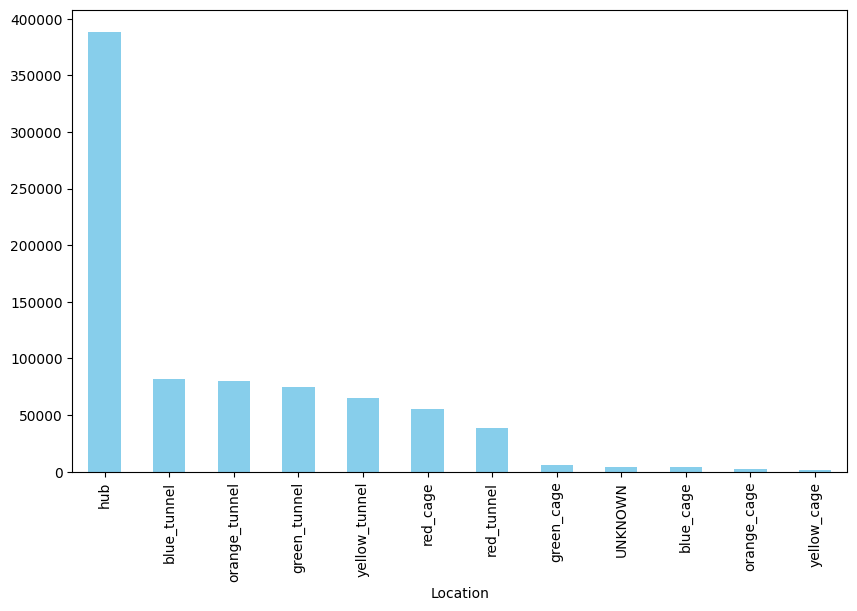

In [72]:
processed_df['Location'].value_counts().plot(kind='bar', color='skyblue', figsize=(10, 6))

<Axes: xlabel='Location'>

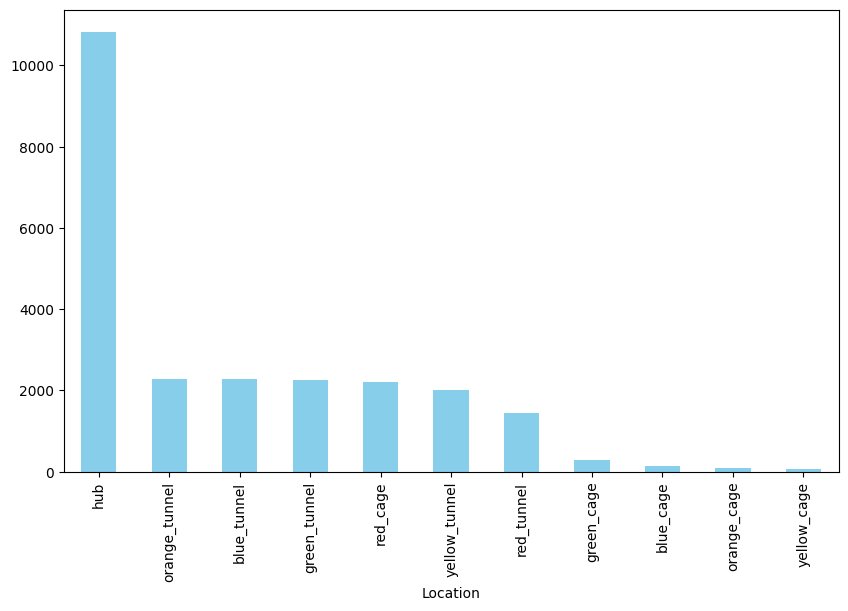

In [74]:
processed_df.loc[(processed_df['Location'] != 'UNKNOWN') & (processed_df['Transponder code'] == '79F8602'), 'Location'].value_counts().plot(kind='bar', color='skyblue', figsize=(10, 6))

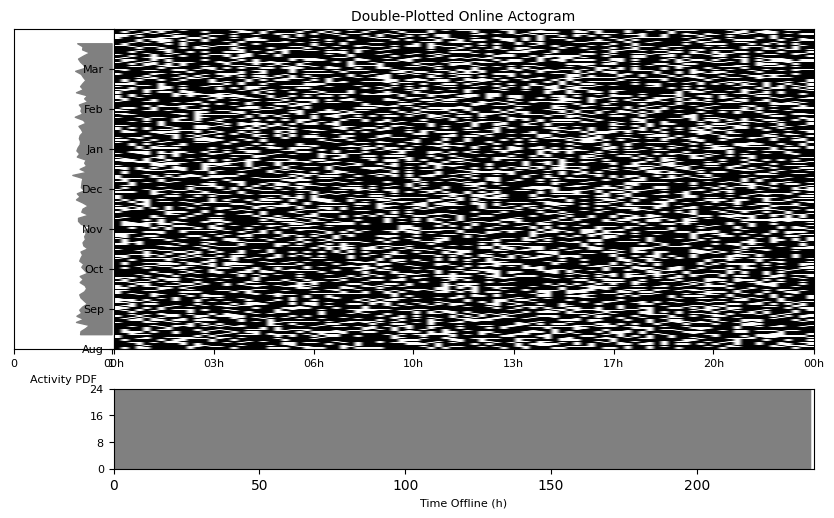

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
num_days = 240  # roughly 8 months of data
minutes_per_day = 1440  # 24 hours x 60 minutes
time_per_bin = 15  # 15-minute increments
bins_per_day = minutes_per_day // time_per_bin

# Generate random activity data (1 for activity, 0 for no activity)
activity_data = np.random.choice([0, 1], size=(num_days, bins_per_day), p=[0.7, 0.3])

# Create the main figure
fig = plt.figure(figsize=(10, 8))

# Activity density plot on the left
activity_density = activity_data.sum(axis=0) / num_days  # Density of activity per bin
left_ax = fig.add_axes([0.05, 0.3, 0.1, 0.4])  # Position for density plot
left_ax.fill_betweenx(np.arange(bins_per_day), 0, activity_density, color='gray')
left_ax.invert_xaxis()
left_ax.set_yticks([])
left_ax.set_xticks([0, 1])
left_ax.set_xticklabels(["1", "0"], fontsize=8)
left_ax.set_xlabel("Activity PDF", fontsize=8)

# Double-plotted actogram
main_ax = fig.add_axes([0.15, 0.3, 0.7, 0.4])  # Position for main actogram
for day in range(num_days):
    day_data = np.tile(activity_data[day], 2)  # Double-plot for overlap
    main_ax.imshow(day_data.reshape(2, -1), aspect='auto', cmap='gray', extent=[0, 2 * bins_per_day, day, day + 1])

main_ax.set_xticks(np.linspace(0, 2 * bins_per_day, 8))  # Hourly ticks every 3 hours
main_ax.set_xticklabels([f"{int(i % 24):02}h" for i in np.linspace(0, 24, 8)], fontsize=8)
main_ax.set_yticks(np.arange(0, num_days, 30))  # Monthly ticks
main_ax.set_yticklabels(["Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar"], fontsize=8)
main_ax.set_title("Double-Plotted Online Actogram", fontsize=10)

# Offline time summary on the bottom
offline_time = minutes_per_day - (activity_data.sum(axis=1) * time_per_bin) / 60  # Calculate offline hours per day
bottom_ax = fig.add_axes([0.15, 0.15, 0.7, 0.1])  # Position for offline time summary
bottom_ax.fill_between(np.arange(num_days), 0, offline_time, color='gray')
bottom_ax.set_xlim(0, num_days)
bottom_ax.set_ylim(0, 24)
bottom_ax.set_yticks([0, 8, 16, 24])
bottom_ax.set_yticklabels(["0", "8", "16", "24"], fontsize=8)
bottom_ax.set_xlabel("Time Offline (h)", fontsize=8)

plt.show()



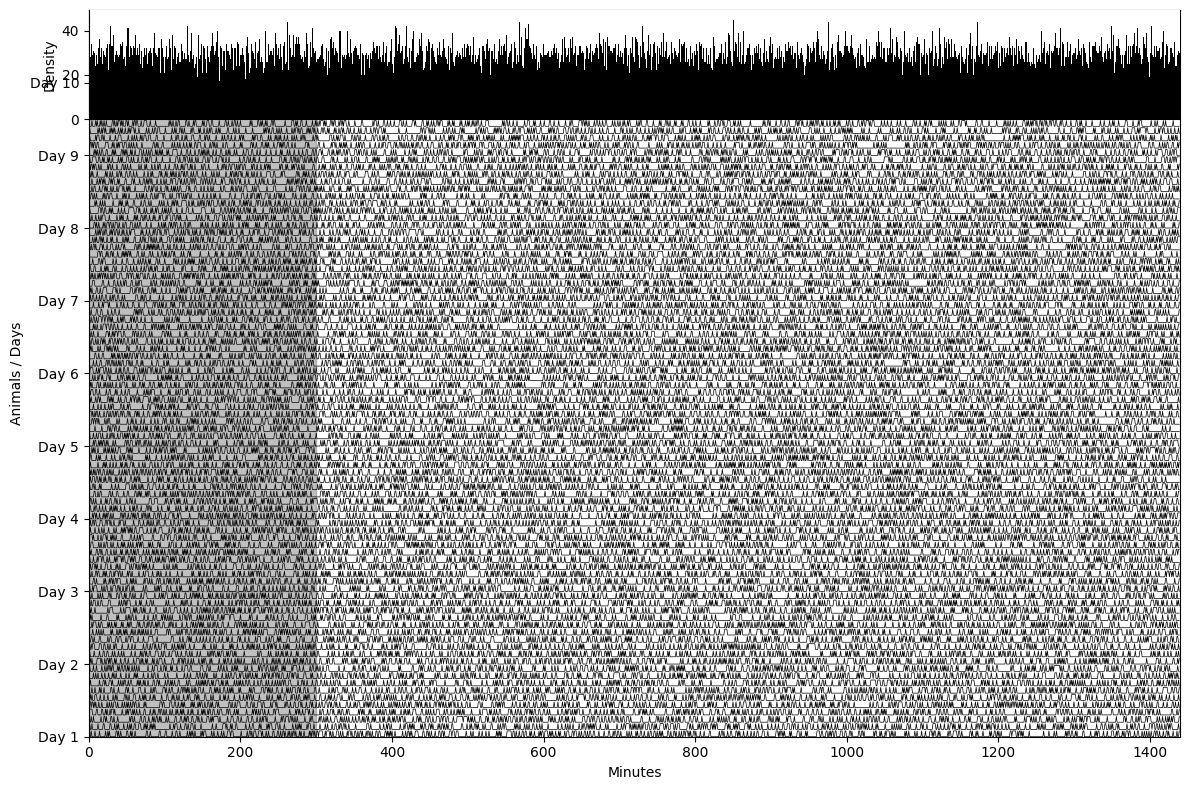

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic activity data (Replace this with your actual data)
num_animals = 10
num_days = 10
minutes_per_day = 1440  # number of minutes in a day
activity_data = np.random.choice([0, 1], size=(num_animals, num_days * minutes_per_day), p=[0.7, 0.3])

# Calculate activity density across time
activity_per_time = activity_data.sum(axis=0).reshape(num_days, minutes_per_day).sum(axis=0)

# Plotting the actogram with a histogram at the top
fig, ax = plt.subplots(figsize=(12, 8))

# Create a top axis for the histogram as an inset axis
top_ax = ax.inset_axes([0, 0.85, 1, 0.15], sharex=ax)  # Small inset at the top for the histogram

# Histogram plot on top
minutes = np.arange(minutes_per_day)
top_ax.bar(minutes, activity_per_time, color="black", width=1)
top_ax.set_xlim(0, minutes_per_day)  # Ensure the histogram spans the full 1440 minutes
top_ax.set_ylabel('Density')
top_ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-ticks
top_ax.spines['top'].set_visible(False)
top_ax.spines['right'].set_visible(False)

# Plot the activity actogram
for i in range(num_animals):
    for day in range(num_days):
        start = day * minutes_per_day
        end = start + minutes_per_day
        activity = activity_data[i, start:end]
        
        time_axis = np.arange(minutes_per_day)
        ax.plot(time_axis, i + activity * 0.8 + day * num_animals, color='black', lw=0.5)

# Adjusting axis labels and plot aesthetics
ax.set_xlim(0, minutes_per_day)
ax.set_ylim(0, num_animals * num_days)
ax.set_yticks(np.arange(0, num_animals * num_days, num_animals))
ax.set_yticklabels([f'Day {day+1}' for day in range(num_days)])
ax.set_xlabel('Minutes')
ax.set_ylabel('Animals / Days')

# Adding night periods (optional)
night_period = [0, 300]  # start and end of night period in minutes (example)
for day in range(num_days):
    ax.fill_betweenx([day * num_animals, (day + 1) * num_animals], night_period[0], night_period[1], color='gray', alpha=0.5)

plt.tight_layout()
plt.show()


In [40]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Generate synthetic timestamps for activity data
num_animals = 10
num_days = 10
minutes_per_day = 1440
activity_data = np.random.choice([0, 1], size=(num_animals, num_days * minutes_per_day), p=[0.7, 0.3])

# Create timestamps based on activity
start_time = datetime.now() - timedelta(days=num_days)
timestamps = []

for day in range(num_days):
    for minute in range(minutes_per_day):
        time = start_time + timedelta(days=day, minutes=minute)
        for animal in range(num_animals):
            if activity_data[animal, day * minutes_per_day + minute] == 1:
                timestamps.append(time)

# Save timestamps to CSV for webactogram
df = pd.DataFrame({'timestamp': timestamps})
df.to_csv('activity_data.csv', index=False)


In [34]:
import pandas as pd
import numpy as np
import os
from itertools import combinations

def calculate_interactions_and_time_per_period(df):
    """
    Calculate interactions and time together for each period separately.
    """
    # Filter out 'hub' and 'tunnel' locations, keep only 'cage' locations
    df = df[df['Location'].str.endswith('_cage')].copy()

    # Ensure 'Time' is in datetime format and sorted
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values('Time')

    # List of periods
    periods = df['Period'].unique()

    results = []

    for period in periods:
        period_df = df[df['Period'] == period].copy()
        
        # List of unique mice in this period
        mice = period_df['Transponder code'].unique()

        if len(mice) < 2:
            continue  # Need at least two mice to calculate interactions

        # Create a DataFrame to track mouse locations over time
        pivot_df = period_df.pivot_table(index='Time', columns='Transponder code', values='Location', aggfunc='first')

        # Forward fill to account for continuous presence
        pivot_df.ffill(inplace=True)

        # Ensure Time is sorted
        pivot_df = pivot_df.sort_index()

        # Calculate time differences between rows
        time_deltas = pivot_df.index.to_series().diff().dt.total_seconds()
        time_deltas.iloc[0] = 0  # First delta is zero

        # Initialize dictionaries to store interactions and time together
        interactions = {}
        time_together = {}

        # For each pair of mice
        for mouse1, mouse2 in combinations(mice, 2):
            # Key for the pair
            pair_key = frozenset((mouse1, mouse2))

            # Get locations over time
            loc1 = pivot_df[mouse1]
            loc2 = pivot_df[mouse2]

            # Both mice are in the same cage
            together = (loc1 == loc2) & loc1.notna() & loc2.notna()

            # Total time together in seconds
            total_time = (together * time_deltas).sum()
            time_together[pair_key] = total_time

            # Calculate interactions
            # An interaction occurs when the 'together' status changes from False to True
            together_shift = together.shift(1, fill_value=False)
            interactions_count = ((~together_shift) & together).sum()
            interactions[pair_key] = interactions_count

        # Prepare the result DataFrame for this period
        data = []
        for mice_pair in interactions.keys():
            m1, m2 = tuple(mice_pair)
            data.append({
                'Period': period,
                'Mouse1': m1,
                'Mouse2': m2,
                'Interactions': interactions[mice_pair],
                'TimeTogether': time_together[mice_pair] / 60  # Convert seconds to minutes
            })
        period_result_df = pd.DataFrame(data)
        results.append(period_result_df)

    # Concatenate all periods
    final_df = pd.concat(results, ignore_index=True)
    return final_df

def main():
    # Load the processed data
    data_path = '../data/processed/rural/RFID_processed.parquet'
    if not os.path.exists(data_path):
        print(f"Data file not found at `{data_path}`.")
        return
    df = pd.read_parquet(data_path)

    # Calculate interactions and time together per period
    result_df = calculate_interactions_and_time_per_period(df)

    # Save the result to a Parquet file
    output_path = '../data/processed/mouse_interactions_per_period.parquet'
    result_df.to_parquet(output_path, index=False)
    print(f"Interactions and time together data saved to {output_path}")

if __name__ == '__main__':
    main()

C:\Users\joshf\AppData\Local\Temp\ipykernel_30816\375690722.py:42: SettingWithCopyWarning:

modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.

C:\Users\joshf\AppData\Local\Temp\ipykernel_30816\375690722.py:42: SettingWithCopyWarning:

modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.

C:\Users\joshf\AppData\Local\Temp\ipykernel_30816\375690722.py:42: SettingWithCopyWarning:

modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.

C:\Users\joshf\AppData\Local\Temp\ipykernel_30816\375690722.py:42: SettingWithCopyWarning:

modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.

C:\Users\joshf\AppData\Local\Temp\ipykernel_30816\375690722.py:42: SettingWithCopyWarning:

modifications to a method of a datetimelike object are not s

Interactions and time together data saved to ../data/processed/mouse_interactions_per_period.parquet


In [36]:
result_df

,Time,Location,Unit number,Transponder code,Period
0,2024-03-02 03:43:53,UNKNOWN,9,79F8602,1
1,2024-03-02 03:43:55,green_tunnel,4,79F8602,1
2,2024-03-02 03:44:04,hub,2,79F8602,1
3,2024-03-02 03:44:05,orange_tunnel,7,79F8602,1
4,2024-03-02 03:45:07,hub,7,79F8602,1
...,...,...,...,...,...
23921,2024-06-04 23:58:11,blue_tunnel,5,79F8602,5
23922,2024-06-04 23:58:15,hub,1,79F8602,5
23923,2024-06-04 23:58:23,hub,1,79F8602,5
23924,2024-06-04 23:58:26,hub,3,79F8602,5


In [ ]:
import os
import glob
import pandas as pd

raw_folder = '../data/raw/'
csv_files = glob.glob(os.path.join(raw_folder, '*.CSV'))

# Dictionary mapping unit number transitions to locations
location_map = {
    (1, 1): {'prior': [2, 3, 4, 5], 'location': 'red_tunnel', 'default': 'hub'},
    (2, 2): {'prior': [1, 3, 4, 5], 'location': 'orange_tunnel', 'default': 'hub'},
    (3, 3): {'prior': [1, 2, 4, 5], 'location': 'yellow_tunnel', 'default': 'hub'},
    (4, 4): {'prior': [1, 2, 3, 5], 'location': 'green_tunnel', 'default': 'hub'},
    (5, 5): {'prior': [1, 2, 3, 4], 'location': 'blue_tunnel', 'default': 'hub'},
    (1, 2): {'location': 'hub'},
    (1, 3): {'location': 'hub'},
    (1, 4): {'location': 'hub'},
    (1, 5): {'location': 'hub'},
    (2, 1): {'location': 'hub'},
    (2, 3): {'location': 'hub'},
    (2, 4): {'location': 'hub'},
    (2, 5): {'location': 'hub'},
    (3, 1): {'location': 'hub'},
    (3, 2): {'location': 'hub'},
    (3, 4): {'location': 'hub'},
    (3, 5): {'location': 'hub'},
    (4, 1): {'location': 'hub'},
    (4, 2): {'location': 'hub'},
    (4, 3): {'location': 'hub'},
    (4, 5): {'location': 'hub'},
    (5, 1): {'location': 'hub'},
    (5, 2): {'location': 'hub'},
    (5, 3): {'location': 'hub'},
    (5, 4): {'location': 'hub'},
    (1, 6): {'location': 'red_tunnel'},
    (6, 1): {'location': 'red_tunnel'},
    (6, 6): {'location': 'red_cage'},
    (2, 7): {'location': 'orange_tunnel'},
    (7, 2): {'location': 'orange_tunnel'},
    (7, 7): {'location': 'orange_cage'},
    (3, 8): {'location': 'yellow_tunnel'},
    (8, 3): {'location': 'yellow_tunnel'},
    (8, 8): {'location': 'yellow_cage'},
    (4, 9): {'location': 'green_tunnel'},
    (9, 4): {'location': 'green_tunnel'},
    (9, 9): {'location': 'green_cage'},
    (5, 10): {'location': 'blue_tunnel'},
    (10, 5): {'location': 'blue_tunnel'},
    (10, 10): {'location': 'blue_cage'},
    (1, 7): {'location': 'orange_tunnel'},
    (1, 8): {'location': 'yellow_tunnel'},
    (1, 9): {'location': 'green_tunnel'},
    (1, 10): {'location': 'blue_tunnel'},
    (2, 6): {'location': 'red_tunnel'},
    (2, 8): {'location': 'yellow_tunnel'},
    (2, 9): {'location': 'green_tunnel'},
    (2, 10): {'location': 'blue_tunnel'},
    (3, 6): {'location': 'red_tunnel'},
    (3, 7): {'location': 'orange_tunnel'},
    (3, 9): {'location': 'green_tunnel'},
    (3, 10): {'location': 'blue_tunnel'},
    (4, 6): {'location': 'red_tunnel'},
    (4, 7): {'location': 'orange_tunnel'},
    (4, 8): {'location': 'yellow_tunnel'},
    (4, 10): {'location': 'blue_tunnel'},
    (5, 6): {'location': 'red_tunnel'},
    (5, 7): {'location': 'orange_tunnel'},
    (5, 8): {'location': 'yellow_tunnel'},
    (5, 9): {'location': 'green_tunnel'}
}

for csv_file in csv_files:
    # Extract the date from the file name
    date = os.path.splitext(os.path.basename(csv_file))[0]
    
    # Check if the file is split into parts
    if '_' in date:
        date = date.split('_')[0]
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file, sep=';')
    
    # Combine the split files for April 12
    if date == '20240412':
        csv_file_part2 = csv_file.replace('_1.CSV', '_2.CSV')
        if os.path.exists(csv_file_part2):
            df_part2 = pd.read_csv(csv_file_part2, sep=';')
            df = pd.concat([df, df_part2])
    
    # DATA CLEANING
    # Remove rows with transponder codes 0187A3F31B or 00379FED38
    df = df[df['Transponder code'] != '0187A3F31B']
    df = df[df['Transponder code'] != '00379FED38']
    
    # Remove sensor data
    df = df[df['Transponder code'] != '8000000000']
    df = df[df['Transponder code'] != '8000000001']
    df = df[df['Transponder code'] != '8000000002']
    df = df[df['Transponder code'] != '8000000003']
    
    # Get the unique transponder codes
    transponder_codes = df['Transponder code'].unique()
    
    # Iterate over each transponder code
    for transponder_code in transponder_codes:
        # Select the data for the current mouse
        mouse_data = df[df['Transponder code'] == transponder_code].copy()  # Create a copy of the slice
        
        # Convert the 'Date' and 'Time' columns to datetime
        mouse_data.loc[:, 'DateTime'] = pd.to_datetime(mouse_data['Date'] + ' ' + mouse_data['Time'], format='%d-%m-%Y %H:%M:%S')
        
        # Sort the DataFrame by 'DateTime'
        mouse_data = mouse_data.sort_values('DateTime')
        
        # Create a boolean mask to identify duplicate rows within a 1-second time window
        mask = mouse_data.groupby('Unit number')['DateTime'].diff().gt(pd.Timedelta(seconds=1))
        
        # Drop duplicate rows based on the boolean mask
        mouse_data = mouse_data[mask | ~mouse_data['Unit number'].duplicated()]
        
        # Reset the index of the DataFrame
        mouse_data = mouse_data.reset_index(drop=True)
        
        # Create a single time column with the desired format
        mouse_data.loc[:, 'Time'] = mouse_data['DateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
        
        # Drop the original 'Date' and 'Time' columns
        mouse_data = mouse_data.drop(['Date', 'Time'], axis=1)
        
        mouse_data = mouse_data[['DateTime', 'Unit number', 'Transponder code']]
        
        # Rename DateTime column to Time
        mouse_data = mouse_data.rename(columns={'DateTime': 'Time'})
        
        # Initialize an empty list to store the results
        results = []
        
        # Iterate over each row of the mouse_data DataFrame
        for i in range(len(mouse_data)):
            current_unit = mouse_data.iloc[i]['Unit number']
            current_time = mouse_data.iloc[i]['Time']
            
            if i == 0:
                # For the first row, set the location as "UNKNOWN"
                location = 'UNKNOWN'
            elif i == 1:
                # For the second row, set the location based on the transition
                prev_unit = mouse_data.iloc[i-1]['Unit number']
                transition = (prev_unit, current_unit)
                
                if transition in location_map:
                    location = location_map[transition]['location']
                else:
                    location = 'UNKNOWN'
            else:
                prev_unit = mouse_data.iloc[i-1]['Unit number']
                prev_location = results[-1][1]  # Get the previous location from the results list
                transition = (prev_unit, current_unit)
                
                if transition in location_map:
                    if 'prior' in location_map[transition]:
                        if prev_unit in location_map[transition]['prior']:
                            location = location_map[transition]['location']
                        else:
                            location = location_map[transition]['default']
                    else:
                        location = location_map[transition]['location']
                else:
                    location = 'UNKNOWN'
                
                # Check if the mouse moved from a tunnel to a specific antenna unit number
                if prev_location == 'green_tunnel' and current_unit == 4:
                    if results[-2][1] == 'UNKNOWN':
                        results[-2][1] = 'hub'  # Modify the location two rows before the current location
                elif prev_location == 'red_tunnel' and current_unit == 1:
                    if results[-2][1] == 'UNKNOWN':
                        results[-2][1] = 'hub'
                elif prev_location == 'orange_tunnel' and current_unit == 2:
                    if results[-2][1] == 'UNKNOWN':
                        results[-2][1] = 'hub'
                elif prev_location == 'yellow_tunnel' and current_unit == 3:
                    if results[-2][1] == 'UNKNOWN':
                        results[-2][1] = 'hub'
                elif prev_location == 'blue_tunnel' and current_unit == 5:
                    if results[-2][1] == 'UNKNOWN':
                        results[-2][1] = 'hub'
                
                # Check if the mouse moved from hub to tunnel to specific unit number
                if i >= 2:
                    prev_prev_location = results[-2][1]  # Get the location two rows before the current location
                    if prev_prev_location == 'hub' and prev_location == 'green_tunnel' and current_unit == 4:
                        location = 'hub'
                    elif prev_prev_location == 'hub' and prev_location == 'red_tunnel' and current_unit == 1:
                        location = 'hub'
                    elif prev_prev_location == 'hub' and prev_location == 'orange_tunnel' and current_unit == 2:
                        location = 'hub'
                    elif prev_prev_location == 'hub' and prev_location == 'yellow_tunnel' and current_unit == 3:
                        location = 'hub'
                    elif prev_prev_location == 'hub' and prev_location == 'blue_tunnel' and current_unit == 5:
                        location = 'hub'
            
            # Append the result to the list
            results.append([current_time, location, current_unit])
        
        # Create a new DataFrame with the desired columns
        result_df = pd.DataFrame(results, columns=['Time', 'Location', 'Unit number'])
        
        # Apply the additional logic
        for i in range(1, len(result_df)):
            prev_location = result_df.iloc[i-1]['Location']
            current_transition = (result_df.iloc[i-1]['Unit number'], result_df.iloc[i]['Unit number'])
            
            if prev_location == 'red_cage' and current_transition == (6, 6):
                result_df.at[i, 'Location'] = 'red_tunnel'
            elif prev_location == 'orange_cage' and current_transition == (7, 7):
                result_df.at[i, 'Location'] = 'orange_tunnel'
            elif prev_location == 'yellow_cage' and current_transition == (8, 8):
                result_df.at[i, 'Location'] = 'yellow_tunnel'
            elif prev_location == 'green_cage' and current_transition == (9, 9):
                result_df.at[i, 'Location'] = 'green_tunnel'
            elif prev_location == 'blue_cage' and current_transition == (10, 10):
                result_df.at[i, 'Location'] = 'blue_tunnel'
                
            # New logic: If previous row contains a 6 and current row contains a 6, then current location should be red_cage
            if result_df.iloc[i-1]['Unit number'] == 6 and result_df.iloc[i]['Unit number'] == 6:
                result_df.at[i, 'Location'] = 'red_cage'
        
        # Fill in the missing seconds in the time column
        start_time = pd.to_datetime(mouse_data['Time'].min())
        end_time = pd.to_datetime(mouse_data['Time'].max())
        all_seconds = pd.date_range(start=start_time, end=end_time, freq='S')
        
        # Merge the result DataFrame with the complete time range
        final_df = pd.merge(pd.DataFrame({'Time': all_seconds}), result_df, on='Time', how='left')
        
        # Apply the logic for transitions between cages and tunnels only if the value is UNKNOWN
        for i in range(1, len(final_df)):
            prev_location = final_df.iloc[i-1]['Location']
            current_location = final_df.iloc[i]['Location']
            
            if pd.notna(current_location) and current_location == 'UNKNOWN' and \
               pd.notna(prev_location) and (prev_location.endswith('_cage') or prev_location.endswith('_tunnel')) and \
               (current_location.endswith('_cage') or current_location.endswith('_tunnel')) and \
               prev_location != current_location:
                final_df.at[i, 'Location'] = 'hub'
        
        final_df['Location'] = final_df['Location'].fillna('UNKNOWN')
        final_df['Unit number'] = final_df['Unit number'].fillna(0).astype(int)
        
        # Save the final DataFrame as a CSV file
        output_folder = f'../data/processed/{date}/'
        os.makedirs(output_folder, exist_ok=True)
        final_df.to_csv(os.path.join(output_folder, f'mouse_{transponder_code}_locations.csv'), index=False)

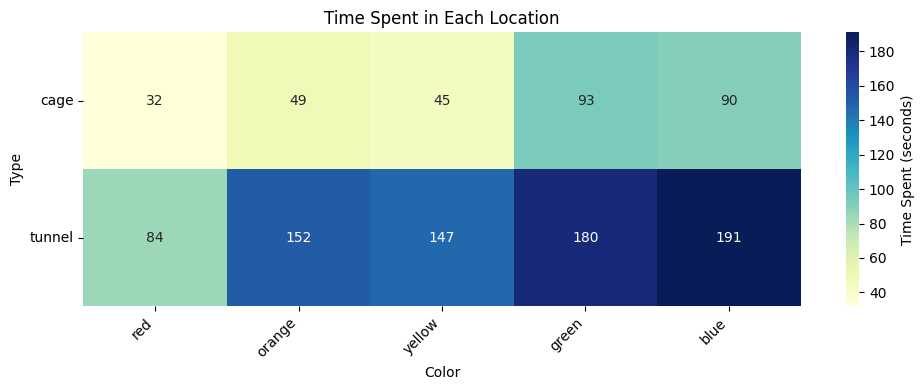

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the data
df = pd.read_csv('../data/processed/mouse_locations.csv')

# Convert the 'Time' column to datetime type
df['Time'] = pd.to_datetime(df['Time'])

# Calculate the time differences between consecutive rows
df['time_diff'] = df['Time'].diff().dt.total_seconds()

# Filter out rows with 'UNKNOWN' and 'hub' locations
df = df[(df['Location'] != 'UNKNOWN') & (df['Location'] != 'hub')]

# Define the order of locations for the heatmap
location_order = ['red_tunnel', 'orange_tunnel', 'yellow_tunnel', 'green_tunnel', 'blue_tunnel',
                  'red_cage', 'orange_cage', 'yellow_cage', 'green_cage', 'blue_cage']

# Filter the DataFrame to include only the desired locations
df = df[df['Location'].isin(location_order)]

# Group by location and sum the time differences
time_spent = df.groupby('Location')['time_diff'].sum()

# Create a DataFrame with the time spent for each location
heatmap_data = pd.DataFrame({'Location': time_spent.index, 'Time Spent (seconds)': time_spent.values})

# Split the location into color and type
heatmap_data[['Color', 'Type']] = heatmap_data['Location'].str.split('_', expand=True)

# Create a pivot table with type as rows, color as columns, and time spent as values
heatmap_matrix = heatmap_data.pivot_table(index='Type', columns='Color', values='Time Spent (seconds)', aggfunc='sum')

# Reorder the columns based on the desired color order
color_order = ['red', 'orange', 'yellow', 'green', 'blue']
heatmap_matrix = heatmap_matrix[color_order]

# Create the heatmap using seaborn
plt.figure(figsize=(10, 4))
sns.heatmap(heatmap_matrix, annot=True, cmap='YlGnBu', fmt='g', cbar_kws={'label': 'Time Spent (seconds)'})

# Adjust the plot labels
plt.xlabel('Color')
plt.ylabel('Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, va='center')

plt.title('Time Spent in Each Location')
plt.tight_layout()
plt.show()

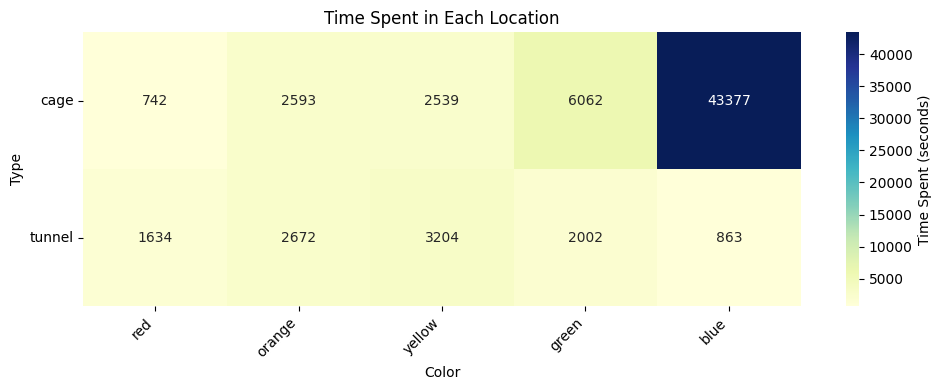

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the data
df = pd.read_csv('../data/processed/mouse_locations.csv')

# Convert the 'Time' column to datetime type
df['Time'] = pd.to_datetime(df['Time'])

# Remove rows where unit number is 0
df = df[df['Unit number'] != 0]

# Calculate the time differences between consecutive rows
df['time_diff'] = df['Time'].diff().dt.total_seconds()

# Replace NaN values with 0 for the first occurrence of each location
df['time_diff'].fillna(0, inplace=True)

# Filter out rows with 'UNKNOWN' and 'hub' locations
df = df[(df['Location'] != 'UNKNOWN') & (df['Location'] != 'hub')]

# Define the order of locations for the heatmap
location_order = ['red_tunnel', 'orange_tunnel', 'yellow_tunnel', 'green_tunnel', 'blue_tunnel',
                  'red_cage', 'orange_cage', 'yellow_cage', 'green_cage', 'blue_cage']

# Filter the DataFrame to include only the desired locations
df = df[df['Location'].isin(location_order)]

# Group by location and sum the time differences
time_spent = df.groupby('Location')['time_diff'].sum()

# Create a DataFrame with the time spent for each location
heatmap_data = pd.DataFrame({'Location': time_spent.index, 'Time Spent (seconds)': time_spent.values})

# Split the location into color and type
heatmap_data[['Color', 'Type']] = heatmap_data['Location'].str.split('_', expand=True)

# Create a pivot table with type as rows, color as columns, and time spent as values
heatmap_matrix = heatmap_data.pivot_table(index='Type', columns='Color', values='Time Spent (seconds)', aggfunc='sum')

# Reorder the columns based on the desired color order
color_order = ['red', 'orange', 'yellow', 'green', 'blue']
heatmap_matrix = heatmap_matrix[color_order]

# Create the heatmap using seaborn
plt.figure(figsize=(10, 4))
sns.heatmap(heatmap_matrix, annot=True, cmap='YlGnBu', fmt='g', cbar_kws={'label': 'Time Spent (seconds)'})

# Adjust the plot labels
plt.xlabel('Color')
plt.ylabel('Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, va='center')

plt.title('Time Spent in Each Location')
plt.tight_layout()
plt.show()

In [ ]:
df['location'].value_counts()

KeyError: 'location'